torch.Size([1, 1, 100, 100])
(1, 1, 2, 2)
[[[[20. 20.]
   [80. 20.]]]]
torch.Size([1, 1, 1, 2])
tensor([[[[1., 0.]]]])


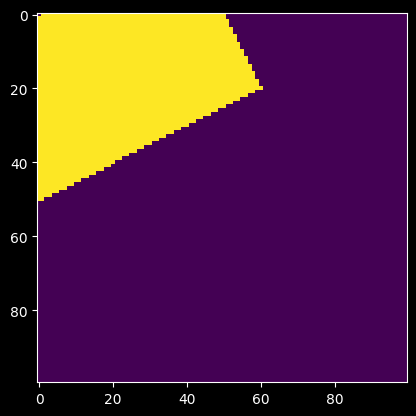

In [1]:
from PIL import Image, ImageDraw, ImageOps, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch


size = (100,100)
img_wp = Image.new('L', size)
draw_wp = ImageDraw.Draw(img_wp)
draw_wp.line((0,0,20,40), fill=1, width=90)
N = 1
C = 1
img_ = np.array(img_wp)
img = img_.reshape(N,C,100,100).astype(np.float32)
img = torch.tensor(img)
print(img.shape)
p = np.array([[20,20],[80,20]]).astype(np.float32)
p = p.reshape(N,1,2,2)
# 1表示的是query
# 第1个2表示点的个数
print(p.shape)
print(p)
p[...,0] /= 100
p[...,1] /= 100
p = (p - 0.5)*2
p = torch.tensor(p)
sampled_feat = F.grid_sample(img, p, align_corners=False)
print(sampled_feat.shape)
print(sampled_feat)
plt.imshow(img_)
# (N,C,1,2)b

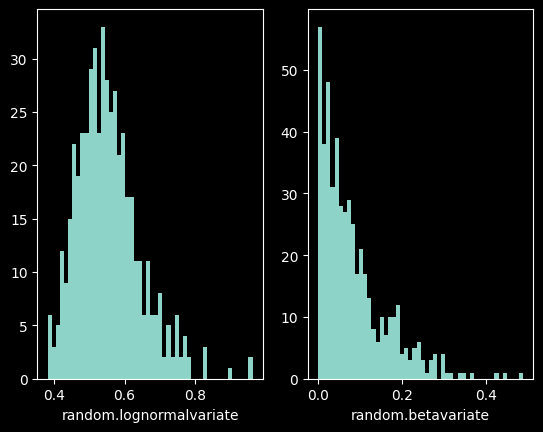

<class 'torch.Tensor'>
tensor(3.6894)


In [18]:

import torch

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    将源域数据和目标域数据转化为核矩阵，即上文中的K
    Params: 
	    source: 源域数据（n * len(x))
	    target: 目标域数据（m * len(y))
	    kernel_mul: 
	    kernel_num: 取不同高斯核的数量
	    fix_sigma: 不同高斯核的sigma值
	Return:
		sum(kernel_val): 多个核矩阵之和
    '''
    n_samples = int(source.size()[0])+int(target.size()[0])# 求矩阵的行数，一般source和target的尺度是一样的，这样便于计算
    total = torch.cat([source, target], dim=0)#将source,target按列方向合并
    #将total复制（n+m）份
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    #将total的每一行都复制成（n+m）行，即每个数据都扩展成（n+m）份
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    #求任意两个数据之间的和，得到的矩阵中坐标（i,j）代表total中第i行数据和第j行数据之间的l2 distance(i==j时为0）
    L2_distance = ((total0-total1)**2).sum(2) 
    #调整高斯核函数的sigma值
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    #以fix_sigma为中值，以kernel_mul为倍数取kernel_num个bandwidth值（比如fix_sigma为1时，得到[0.25,0.5,1,2,4]
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    #高斯核函数的数学表达式
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    #得到最终的核矩阵
    return sum(kernel_val)#/len(kernel_val)

def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    计算源域数据和目标域数据的MMD距离
    Params: 
	    source: 源域数据（n * len(x))
	    target: 目标域数据（m * len(y))
	    kernel_mul: 
	    kernel_num: 取不同高斯核的数量
	    fix_sigma: 不同高斯核的sigma值
	Return:
		loss: MMD loss
    '''
    batch_size = int(source.size()[0])#一般默认为源域和目标域的batchsize相同
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    #根据式（3）将核矩阵分成4部分
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss#因为一般都是n==m，所以L矩阵一般不加入计算
import random
import matplotlib
import matplotlib.pyplot as plt

SAMPLE_SIZE = 500
buckets = 50

#第一种分布：对数正态分布，得到一个中值为mu，标准差为sigma的正态分布。mu可以取任何值，sigma必须大于零。
plt.subplot(1,2,1)
plt.xlabel("random.lognormalvariate")
mu = -0.6
sigma = 0.15#将输出数据限制到0-1之间
res1 = [random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)]
plt.hist(res1, buckets)

#第二种分布：beta分布。参数的条件是alpha 和 beta 都要大于0， 返回值在0~1之间。
plt.subplot(1,2,2)
plt.xlabel("random.betavariate")
alpha = 1
beta = 10
res2 = [random.betavariate(alpha, beta) for _ in range(1, SAMPLE_SIZE)]
plt.hist(res2, buckets)

plt.show()

from torch.autograd import Variable

#参数值见上段代码
#分别从对数正态分布和beta分布取两组数据
diff_1 = []
for i in range(10):
    diff_1.append([random.lognormvariate(mu, sigma) for _ in range(1, SAMPLE_SIZE)])

diff_2 = []
for i in range(10):
    diff_2.append([random.betavariate(alpha, beta) for _ in range(1, SAMPLE_SIZE)])

# print(diff_1)
# print(diff_2)

X = torch.Tensor(diff_1)
Y = torch.Tensor(diff_2)
X,Y = Variable(X), Variable(Y)
# print(X[0])
# print(X.shape)
# print(Y.shape)
# print(mmd_rbf(X,Y))
Y, X_index = torch.sort(X)
print(type(X))
# print(X[0])
print(mmd_rbf(X,Y))



tensor(6.2405)


In [1]:
from pyecharts.charts import Bar, Line
from pyecharts import options as opts

# 创建一个柱状图对象
# bar = Bar()
# 添加X轴数据
# bar.add_xaxis(["衬衫", "羊毛衫", "雪纺衫", "裤子", "高跟鞋", "袜子"])
# # 添加Y轴数据，设置系列名称和颜色
# bar.add_yaxis("商家A", [5, 20, 36, 10, [40,50], 90], color="#675bba")
# bar.add_yaxis("商家B", [8, 15, 60, 20, 25, 30], color="#d48265")
# # 设置全局配置项，如标题，工具栏等
# bar.set_global_opts(title_opts=opts.TitleOpts(title="主标题: 双十一销量", subtitle="副标题:服饰类"),
#                     toolbox_opts=opts.ToolboxOpts())
attnmap = dict(
    ds=[36.0, 100.0, 36.0, 95.52929621935282, 60.0, 70.0, 39.0, 61.297530455464305, 7.61063111060272, 12.354528388228484, 11.41750310070195, 60.0, 13.78082423883614, 1.3796655946618275, 36.82187034645358, 5.04596284499649, 10.72874886385342, 36.0, 29.418808508725174, 100.0, 5.950164803548759, 100.0, 14.286324690669925, 84.91940790210631, 4.6655999999999995, 0.6046617599999999, 100.0, 36.0, 29.944325999130466, 100.0, 15.120000000000001, 100.0, 0.0009213519268958694, 6.683747269421859e-08, 60.0, 60.0, 42.60768822905825],
    is_=[0.36, 1.0, 0.36, 1.0, 0.6, 0.7, 0.39, 0.65, 0.6, 1.0, 0.42250000000000004, 0.6, 0.6, 1.0, 1.0, 1.0, 0.216, 0.36, 0.36, 1.0, 0.07748295494420535, 1.0, 0.6, 1.0, 0.046655999999999996, 0.006046617599999999, 1.0, 0.36, 1.0, 1.0, 0.1512, 1.0, 9.213519268958693e-06, 6.683747269421858e-10, 0.6, 0.6, 0.6016637440758849],
    rc=[100.0, 100.0, 100.0, 95.52929621935282, 100.0, 100.0, 100.0, 94.30389300840662, 12.684385184337867, 12.354528388228484, 27.023675977992777, 100.0, 22.968040398060232, 1.3796655946618275, 36.82187034645358, 5.04596284499649, 49.67013362895102, 100.0, 81.7189125242366, 100.0, 76.79320965279925, 100.0, 23.810541151116542, 84.91940790210631, 100.0, 100.0, 100.0, 100.0, 29.944325999130466, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 76.52688468946752]
)
bs_box=dict(
    ds=[60.0, 26.54322528003525, 100.0, 52.54818315863481, 50.0, 10.535102690354403, 6.426225, 42.012659749470984, 12.354528388228484, 39.0, 21.16044285806521, 36.12380735651237, 73.58005586484319, 1.433944523459652, 28.62360055427605, 32.191504634390526, 4.060336428182396, 4.6655999999999995, 60.0, 100.0, 76.75874086552848, 34.57352223558562, 2.4766559999999997, 9.828, 4.6655999999999995, 36.0, 12.959999999999999, 100.0, 29.944325999130466, 70.0, 7.683277892801921, 2.3516969226872053, 0.04411755435412618, 0.19651507199999996, 36.0, 60.0, 34.57615747301504],
    is_=[0.6, 0.6, 1.0, 0.65, 0.5, 0.36, 0.06426224999999999, 1.0, 1.0, 0.39, 0.42250000000000004, 1.0, 1.0, 1.0, 1.0, 0.36, 1.0, 0.046655999999999996, 0.6, 1.0, 1.0, 0.36, 0.024766559999999996, 0.09827999999999999, 0.046655999999999996, 0.36, 0.1296, 1.0, 1.0, 0.7, 0.18, 1.0, 0.0004479818047487998, 0.0019651507199999994, 0.36, 0.6, 0.568198165070132],
    rc=[100.0, 44.23870880005875, 100.0, 80.84335870559201, 100.0, 29.264174139873344, 100.0, 42.012659749470984, 12.354528388228484, 100.0, 50.08388842145611, 36.12380735651237, 73.58005586484319, 1.433944523459652, 28.62360055427605, 89.42084620664035, 4.060336428182396, 100.0, 100.0, 100.0, 76.75874086552848, 96.03756176551562, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 29.944325999130466, 100.0, 42.684877182232896, 2.3516969226872053, 98.48068356004894, 100.0, 100.0, 100.0, 73.28604987315936]
)

import pyecharts.options as opts
from pyecharts.charts import Line

# 创建一个Line对象
line = Line()

# 添加x轴和y轴的数据
xs = [f"route_{i}" for i in range(37)]
line.add_xaxis(xs)
line.add_yaxis("attnmap_ds", attnmap['ds'], label_opts=False)
line.add_yaxis("attnmap_is", attnmap['is_'], label_opts=False)
line.add_yaxis("attnmap_rc", attnmap['rc'], label_opts=False)

line.add_yaxis("bs_box_ds", bs_box['ds'], label_opts=False)
line.add_yaxis("bs_box_is", bs_box['is_'], label_opts=False)
line.add_yaxis("bs_box_rc", bs_box['rc'], label_opts=False)

# 设置图表标题和工具栏
line.set_global_opts(title_opts=opts.TitleOpts(title="Weekly Sales"))
line.set_series_opts(linestyle_opts={"opacity": 0})
# 保存或显示图表
# line.render("line.html")

line.render()

'/mnt/disk02/hrz/ndetr/render.html'

In [ ]:
import wandb
wandb.init()

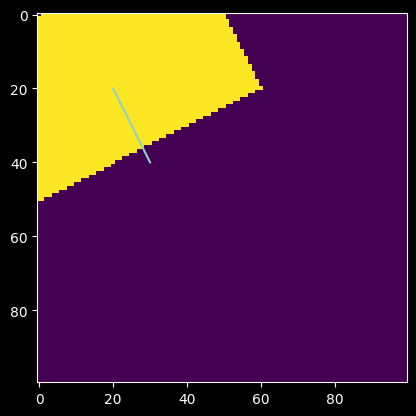

In [3]:
pos = (20,20)
pos2 = (30,40)
plt.imshow(img_)
plt.plot((pos[0],pos2[0]),(pos[1],pos2[1]))

In [4]:
#!/usr/bin/python
#!/usr/bin/env python
#-*- coding:UTF-8 -*-
#from tqdm import tqdm
import mmcv
import numpy as np
import io
import cv2
import time
from petrel_client.client import Client
conf_path = '~/petreloss.conf'
#conf_path = '~/.s3cfg'
client = Client(conf_path)
t1=time.time()
img = []
img_url = 's3://tr_plan_hrz/l6_dataset/Routes_l6_dataset/longest_weathers_0_route0_01_04_22_32_19/rgb/1277.png'
# img_bytes = client.get(img_url)
# img_array = np.frombuffer(img_bytes, np.uint8)
# img_i = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
img_bytes = client.get(img_url)
img = mmcv.imfrombytes(img_bytes)
print(img.shape)

# 's3://tr_plan_hrz/rr_dataset/Routes_Town06_rr/Town06_rr_route5_12_28_07_34_00/rgb/0005.png'

(256, 900, 3)


In [3]:
from mmcv.parallel import DataContainer as DC
import mmcv
import numpy as np

class LoadImageFromCeph:
    def __init__(self, file_client_args=dict(backend='petrel')):
        self.file_client_args = file_client_args.copy()
    def __call__(self, img_path):
        self.file_client = mmcv.FileClient(**self.file_client_args)
        img_bytes = self.file_client.get(img_path)
        img = mmcv.imfrombytes(img_bytes)
        return img
load_img = LoadImageFromCeph()
img = load_img('s3://tr_plan_hrz/l6_dataset/Routes_l6_dataset/longest_weathers_0_route0_01_04_22_32_19/rgb/1277.png')
print(img.shape)

(256, 900, 3)


In [5]:
import time
print(time.strftime('%Y-%m-%d_%H:%M:%S'))
import os.path as osp
osp.splitext(osp.basename("projects/configs/detr3d/new/baseline.py"))

2023-02-09_10:27:52


('baseline', '.py')

In [2]:
import pickle
with open('output/plant_datagen/PlanT_data_1/int_u_s10_dataset/Routes_Town04_Scenario10/Town04_Scenario10_route39_12_29_08_44_03/attnmap/0008.pkl','rb') as f:
    t=pickle.load(f)
print(t.keys())

dict_keys(['attn_map', 'input_idx', 'output_idx', 'output_disappear', 'output_label_path'])


(25, 25)
[3.6463e+04 3.6472e+04 3.6474e+04 3.6511e+04 3.6524e+04 3.6526e+04
 3.6530e+04 3.6557e+04 3.6583e+04 3.6629e+04 3.6641e+04 3.6653e+04
 3.6656e+04 3.6660e+04 3.6698e+04 3.6703e+04 0.0000e+00 1.0000e+00]
(8, 8, 25, 25)
(25, 200)


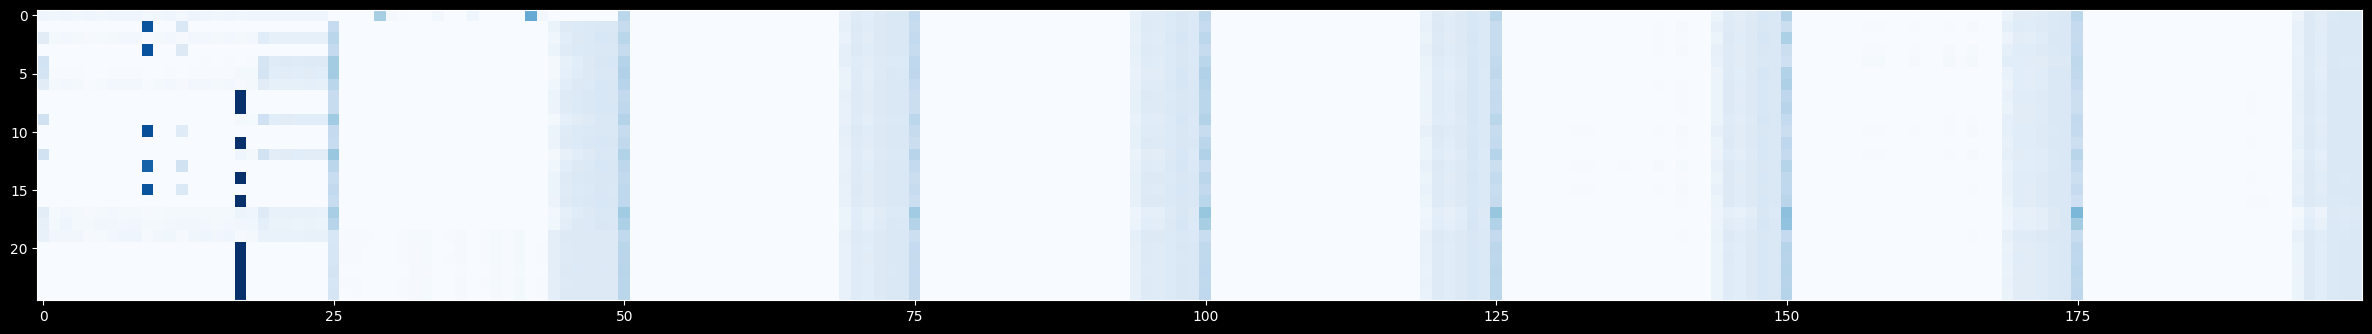

In [3]:
import numpy as np
import matplotlib.pyplot as plt
print(t['attn_map'][0][0].shape)
# plt.imshow(t['attn_map'][0][0])
print(t['input_idx'])
num_box_route = len(t['input_idx'])
num_box = len(t['output_disappear'])
print(t['attn_map'].shape)
att_map = t['attn_map'][0]
att_map = np.concatenate([t for t in att_map],axis=1)
print(att_map.shape)
lena = len(att_map)-1
# print(att_map.shape)
# print(att_map.sum(axis=1))
# print(att_map.sum())

# new = np.zeros((lena+3,lena+3))
# new[1:-1,1:-1]=att_map
# new[0,1] = 1
# new[0,2:2+num_box] = 0.5
# new[0,2+num_box:2+num_box_route] = 0.25
# new[0,2+num_box_route] = 0.1

# new[1,0] = 1
# new[2:2+num_box,0] = 0.5
# new[2+num_box:2+num_box_route,0] = 0.25
# new[2+num_box_route,0] = 0.1

new = att_map

plt.figure(figsize=(30,10))
plt.imshow(new,cmap='Blues')

# TODO: 可视化

In [11]:
import torch
import numpy as np

a = torch.zeros((1,8,53,53))
t = [1,23,4,6,7,52,-1]
x = len(t)
t = torch.tensor(np.array(t))
# t = t[None,None,None].repeat(1,1,x,1)
y = a[:,:,t][:,:,:,t]
# y = a[:,:,t][:,:,:,t]
# print(t.shape)
# y = a[t]
print(y.shape)

torch.Size([1, 8, 7, 7])
